In [4]:

!apt updateapt update
!pip install mdbtools-dev
!apt-get install mdbtools
!pip install pandas pyodbc
!pip install pymssql
!pip install tempfile2
import warnings
warnings.filterwarnings('ignore')

E: Invalid operation updateapt
ERROR: Could not find a version that satisfies the requirement mdbtools-dev (from versions: none)
ERROR: No matching distribution found for mdbtools-dev
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
mdbtools is already the newest version (1.0.0+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 53 not upgraded.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import sys
sys.path.append('/content/drive/MyDrive/Dev/py2/')
import numpy as np

import pandas as pd
from google.colab import files
import os
import subprocess
from io import StringIO  # StringIOを正しくインポート
import model.utility.k_analysis_util as k_a_util
from IPython.display import display

from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

import model.utility.k_analysis_util as k_analysis_util

In [7]:
db_path = "/content/drive/MyDrive/Dev/Kjvan/kjdb_predict_result.accdb"


In [8]:

cmd = f"select * from PredictResults"
print(cmd)

select * from PredictResults


In [9]:
df_re = k_analysis_util.execute_mdb_sql(db_path, cmd)

Standard Output:

pr_program_id	pr_horse_id	pr_rank	pr_h1_pred	pr_h2_pred	pr_h3_pred	pr_h4_pred	pr_hE_pred	upd	pr_race	pr_odds	pr_vote
2025010507	2019103442	11	0.009599999999999999	0.0112	0.3522	0.5473	0.23008	1	08	1761	15
2025010507	2019103825	04	0.0615	0.0276	0.0592	0.3329	0.1203	1	08	0078	06
2025010507	2019105241	02	0.0596	0.0358	0.1018	0.8201000000000001	0.25433	1	08	0156	08
2025010507	2020103435	13	0.0265	0.0218	0.294	0.4388	0.19528	1	08	0755	13
2025010507	2020105156	09	0.0345	0.0527	0.08939999999999999	0.3367	0.12832	1	08	0479	11
2025010507	2020105415	14	0.0304	0.0317	0.039	0.8134	0.22862	1	08	0179	09
2025010507	2020109129	12	0.0119	0.0214	0.0784	0.4367	0.1371	1	08	2116	16
2025010507	2020110127	05	0.1674	0.0541	0.3816	0.8548	0.36447	1	08	0056	02
2025010507	2021101461	10	0.0331	0.0247	0.0718	0.5425	0.16803	1	08	0235	10
2025010507	2021102573	03	0.0844	0.059	0.118	0.5607	0.20552	1	08	0071	05
2025010507	2021102700	08	0.0718	0.0562	0.0177	0.4684	0.15353	1	08	0113	07
2025010507	2021102

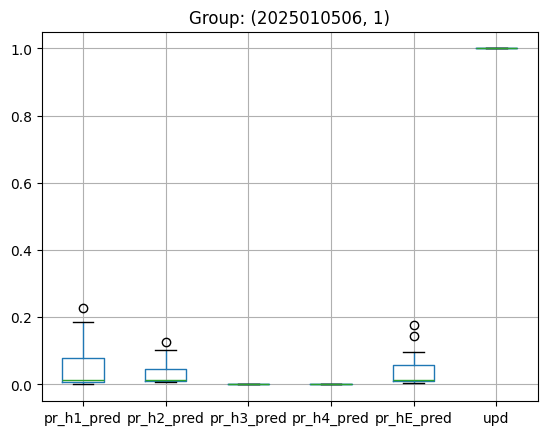

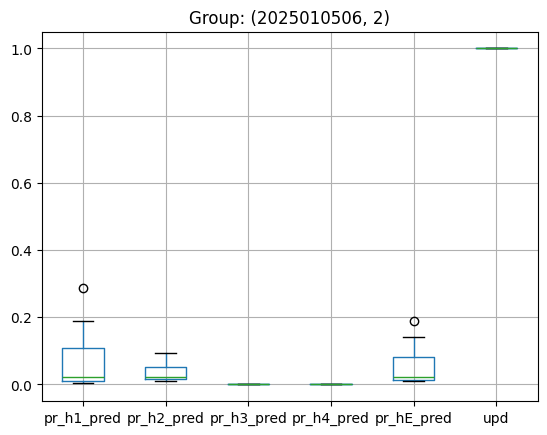

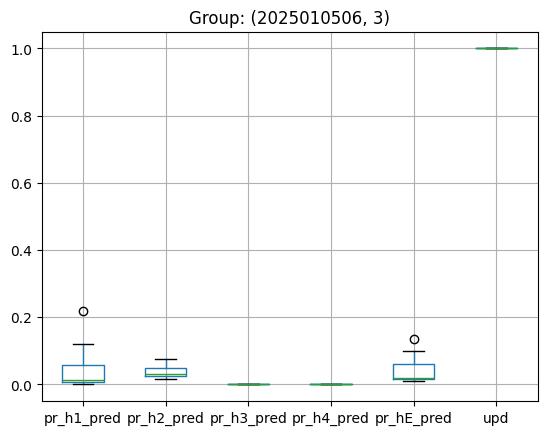

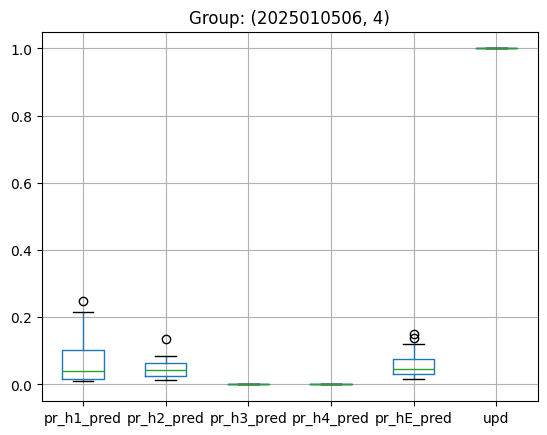

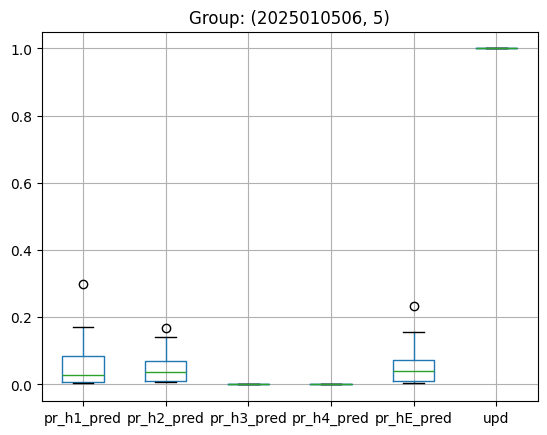

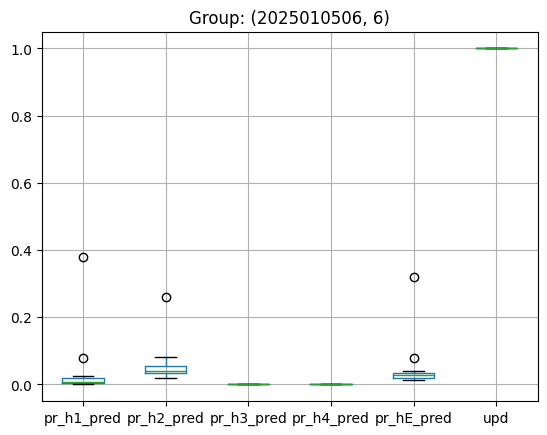

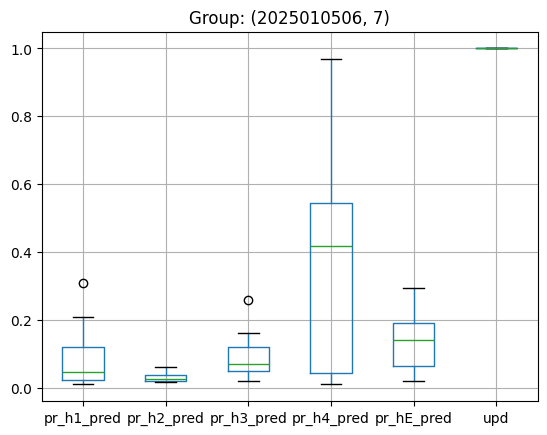

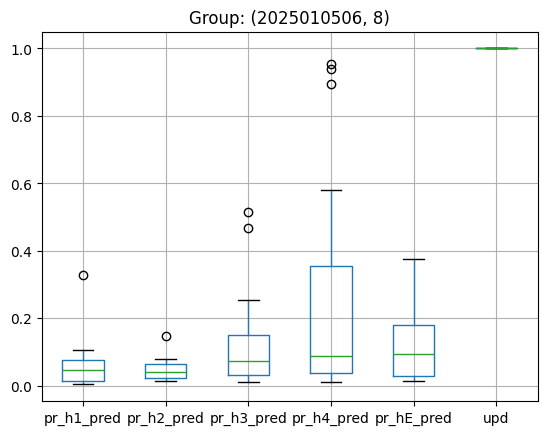

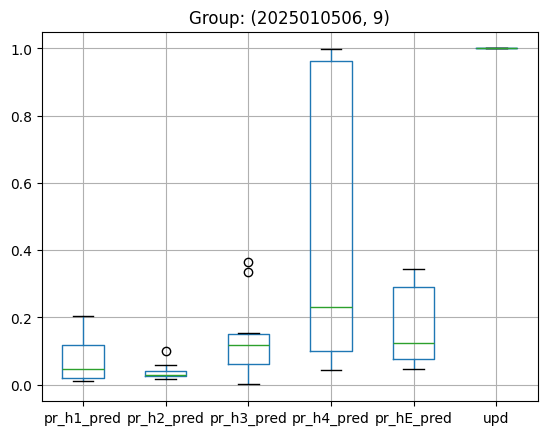

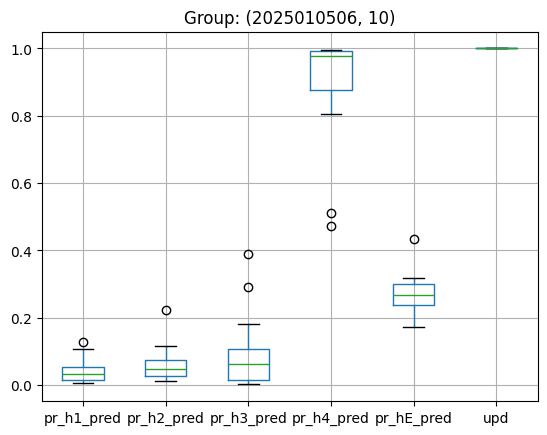

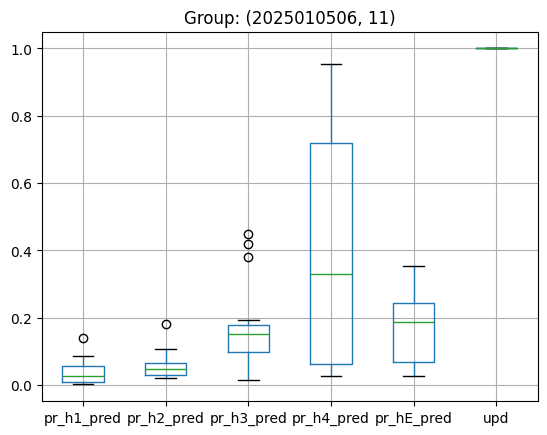

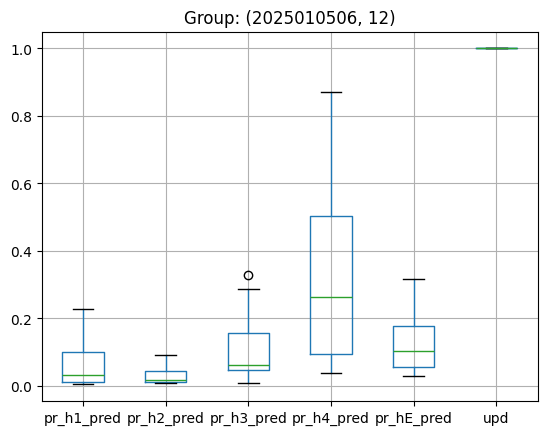

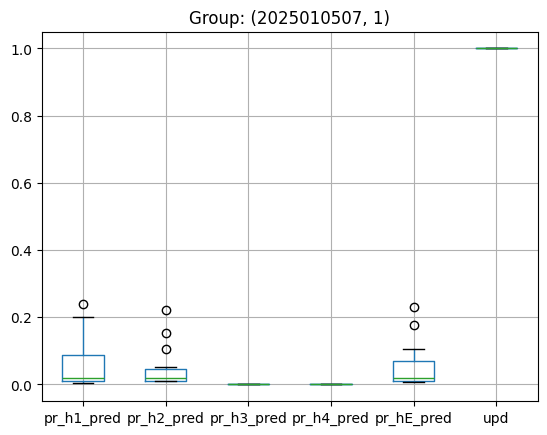

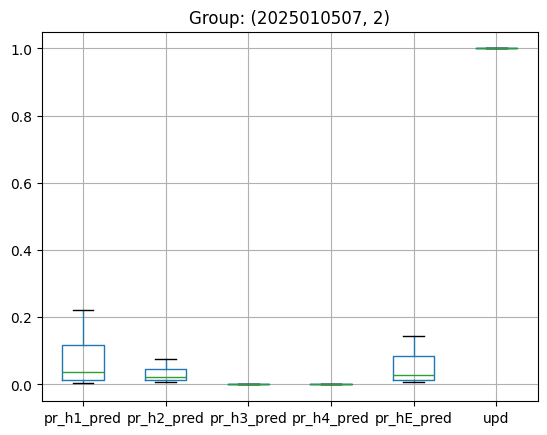

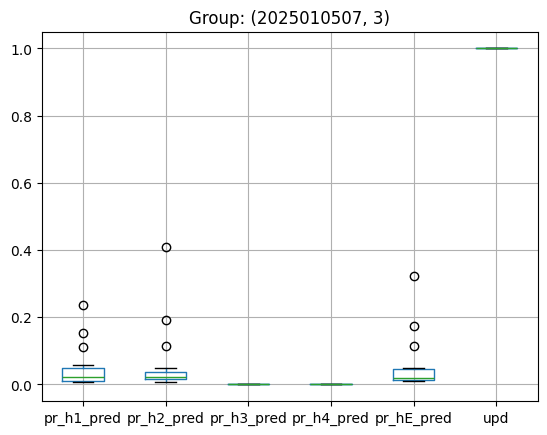

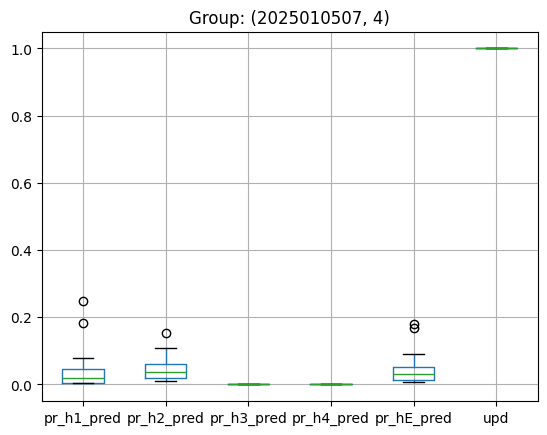

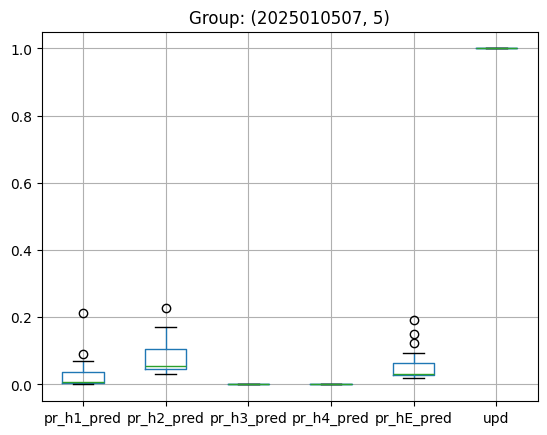

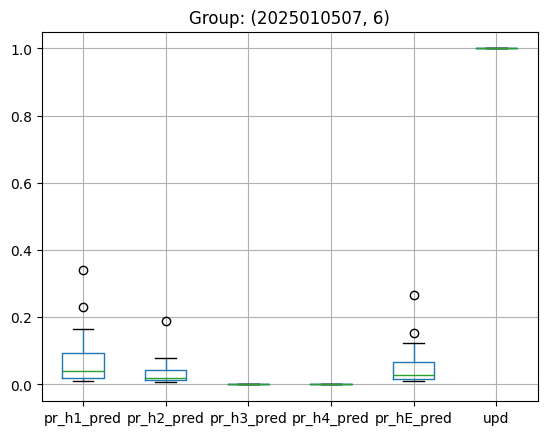

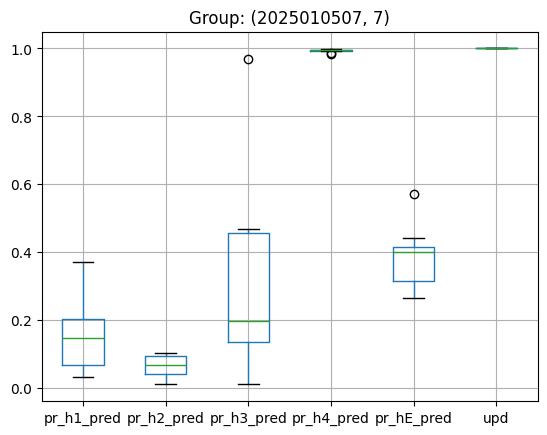

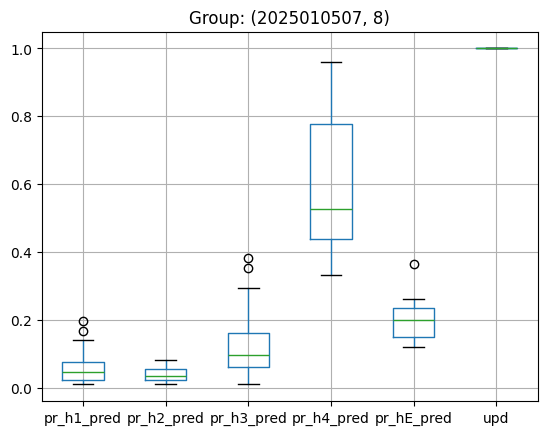

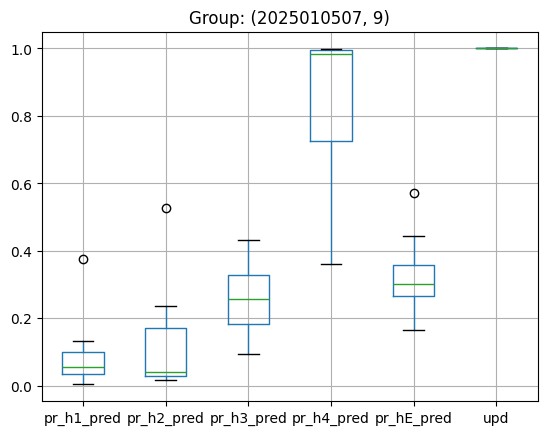

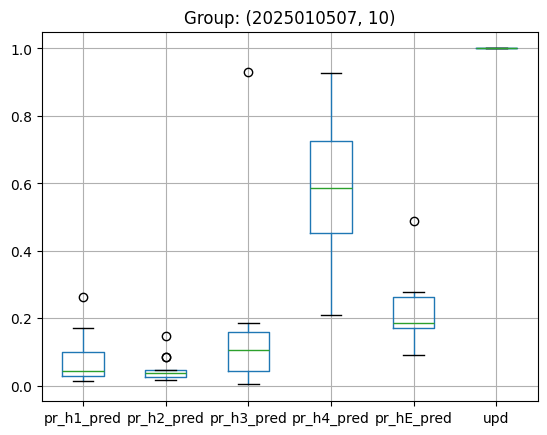

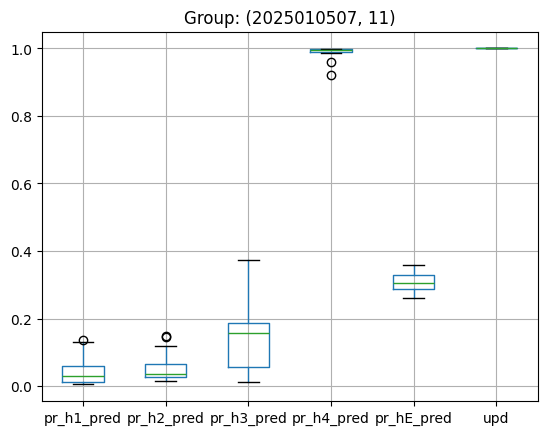

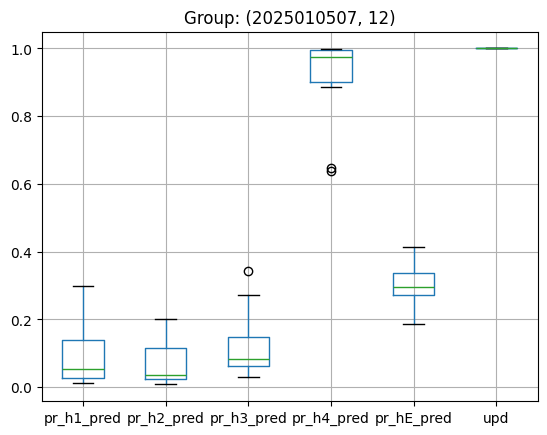

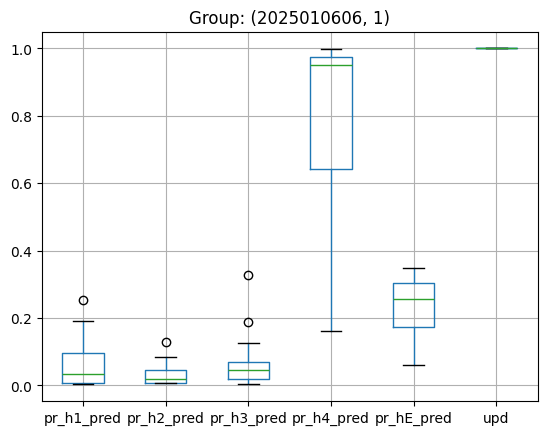

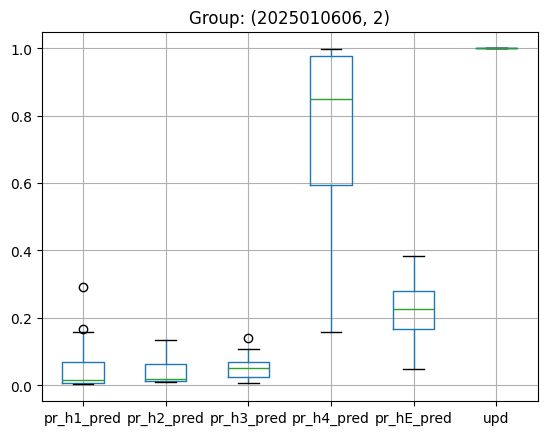

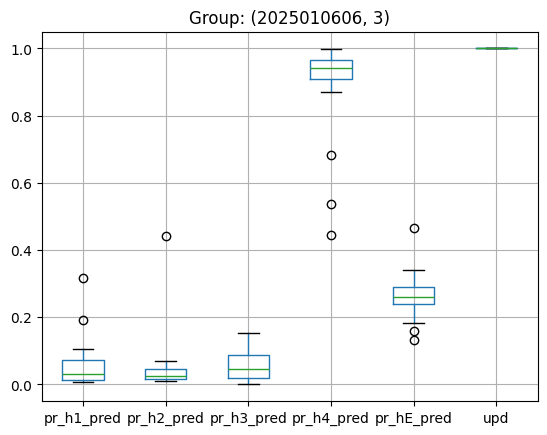

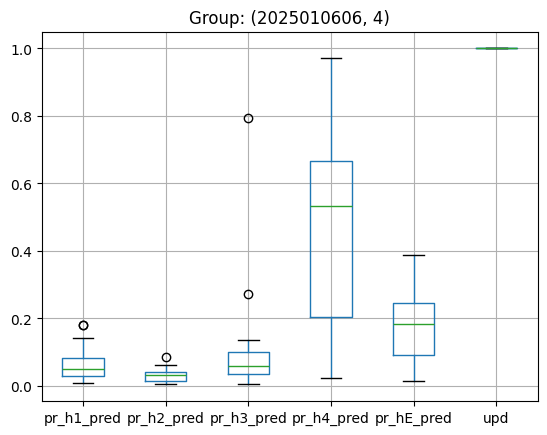

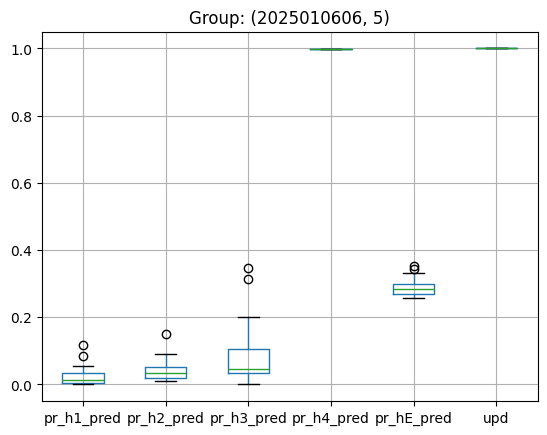

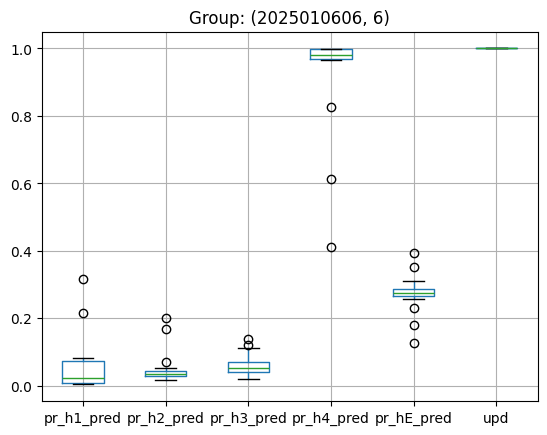

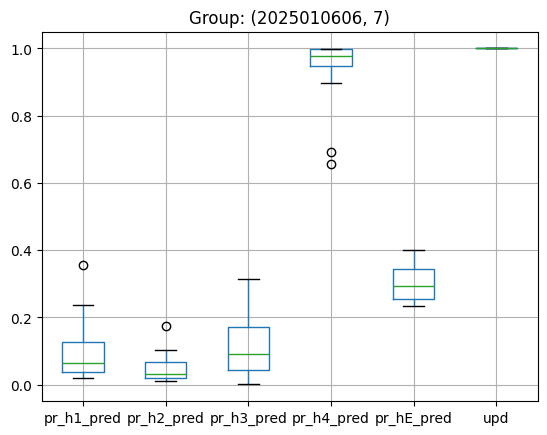

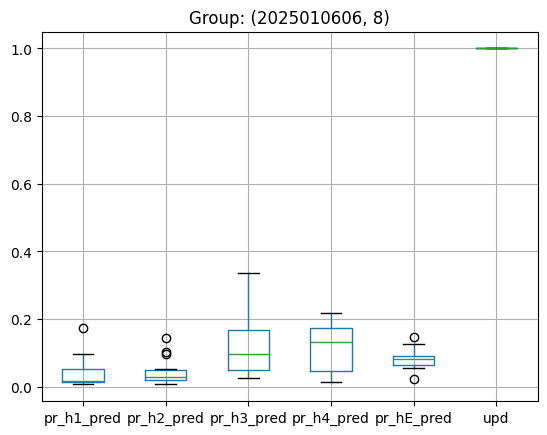

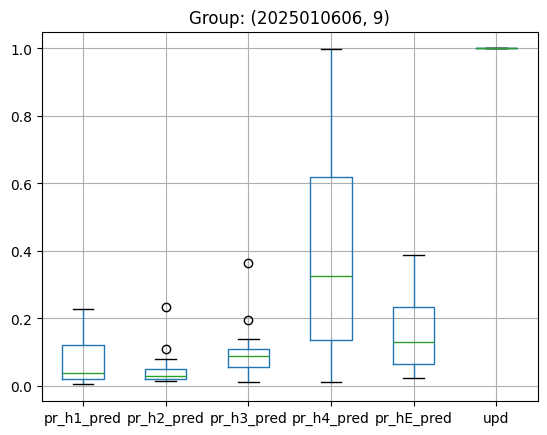

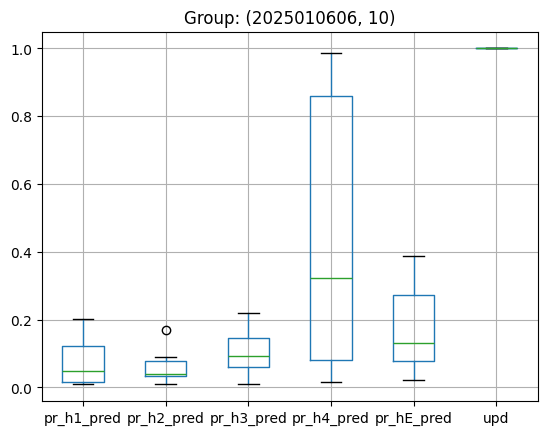

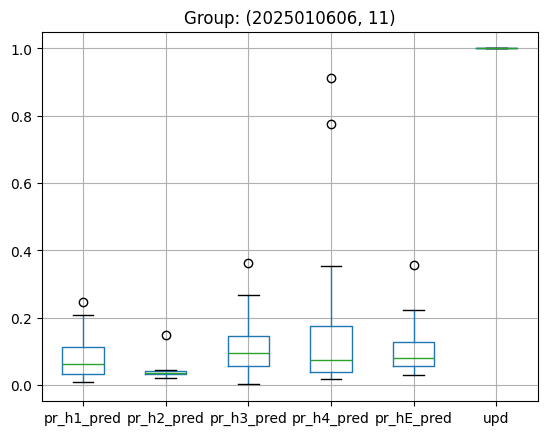

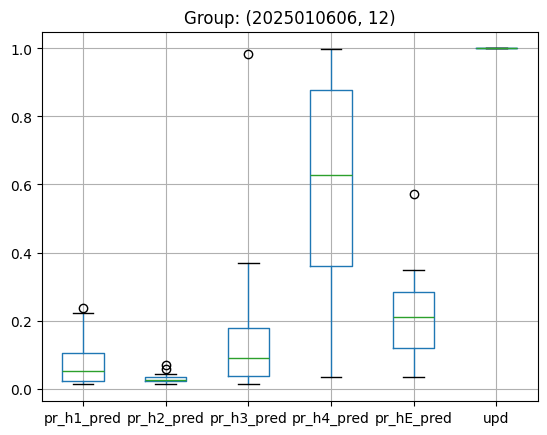

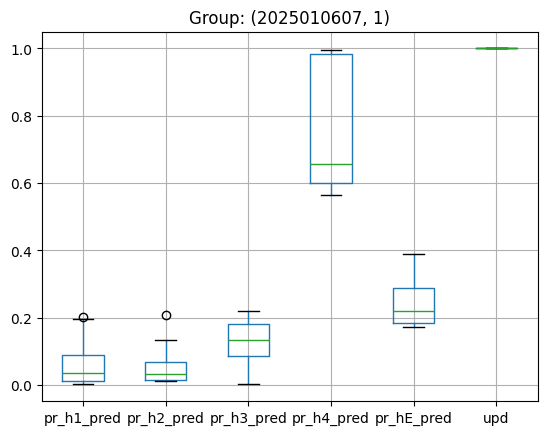

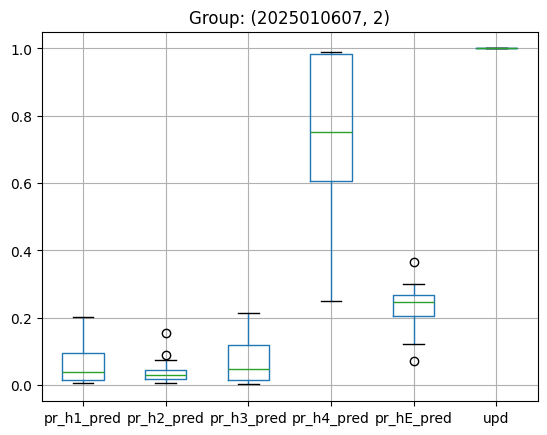

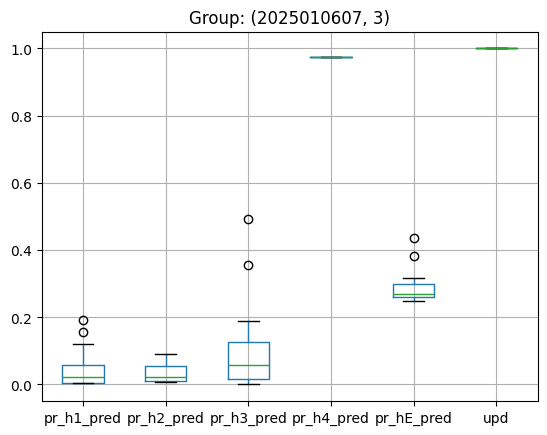

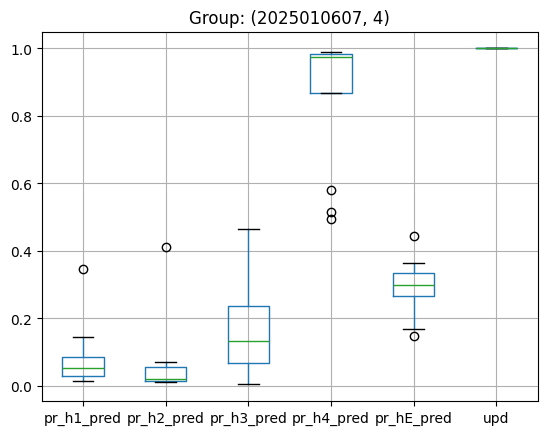

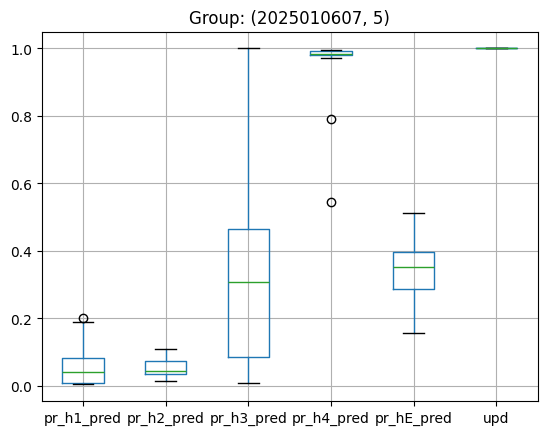

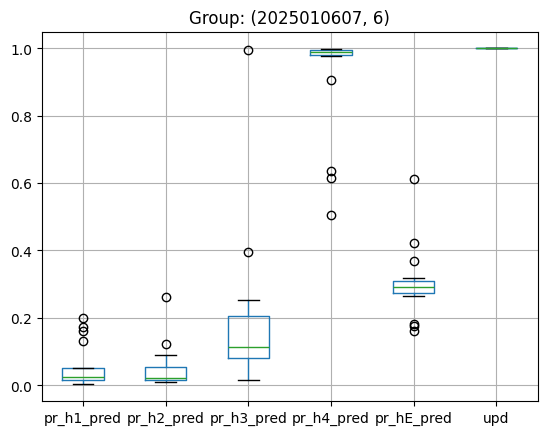

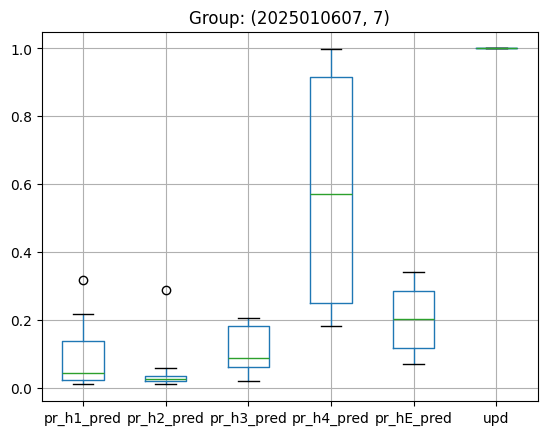

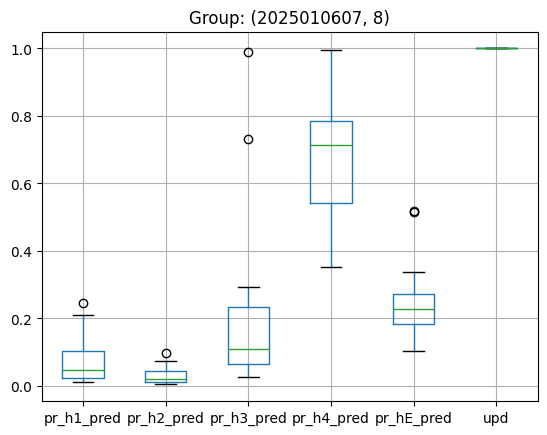

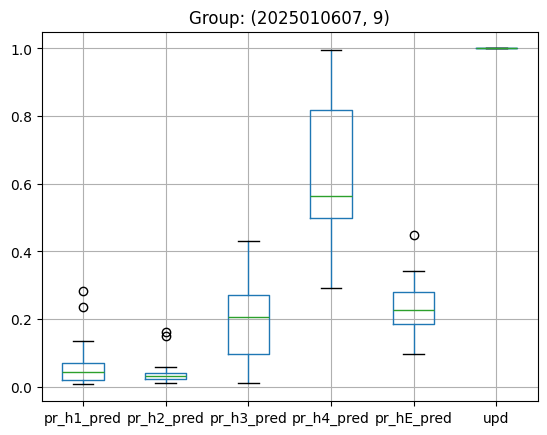

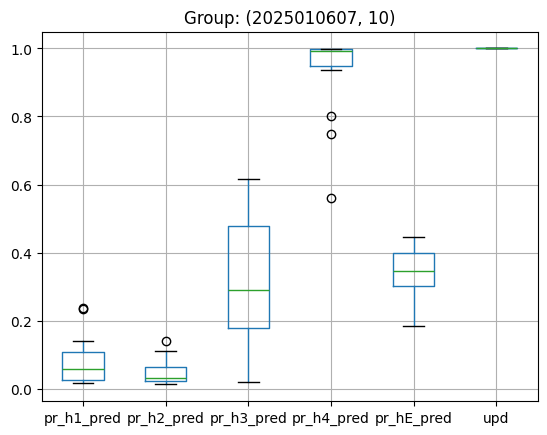

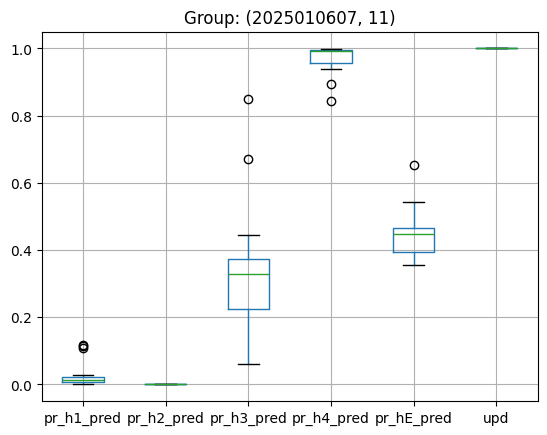

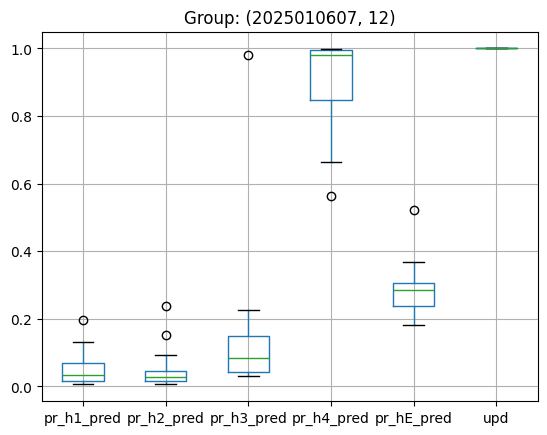

In [10]:
import pandas as pd
import matplotlib.pyplot as plt


# bt_place、bt_distance、bt_track_cdでグループ化
grouped = df_re.groupby(['pr_program_id', 'pr_race'])

# 各グループごとに箱ひげ図を描画
for group_name, group_df in grouped:
    plt.figure()
    group_df.drop([ 'pr_program_id', 'pr_race', 'pr_horse_id', 'pr_odds', 'pr_vote', 'pr_rank'], axis=1).boxplot()
    plt.title(f'Group: {group_name}')
    plt.show()


In [ ]:
#prompt: 以下のコードで行の表示を'pr_horse_id'-'pr_vote'の表記に変更してください
import warnings
from google.colab import drive
import sys
import numpy as np
import pandas as pd
from google.colab import files
import os
import subprocess
from io import StringIO  # StringIOを正しくインポート
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import model.utility.k_analysis_util as k_analysis_util
# 各グループごとにヒートマップを描画
for (program_id, race), group_df in grouped:
    # pr_rankでソート
    sorted_group_df = group_df.sort_values('pr_rank')
    # ヒートマップのデータ作成
    heatmap_data = sorted_group_df[['pr_horse_id', 'pr_h1_pred', 'pr_h2_pred', 'pr_h3_pred', 'pr_h4_pred', 'pr_hE_pred']]
    heatmap_data = heatmap_data.set_index('pr_horse_id')
    plt.figure(figsize=(10, 6))  # 図のサイズ調整
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", center=0) # center=0でグレーを中央に
    plt.title(f'Heatmap for Program ID: {program_id}, Race: {race}')
    plt.show()


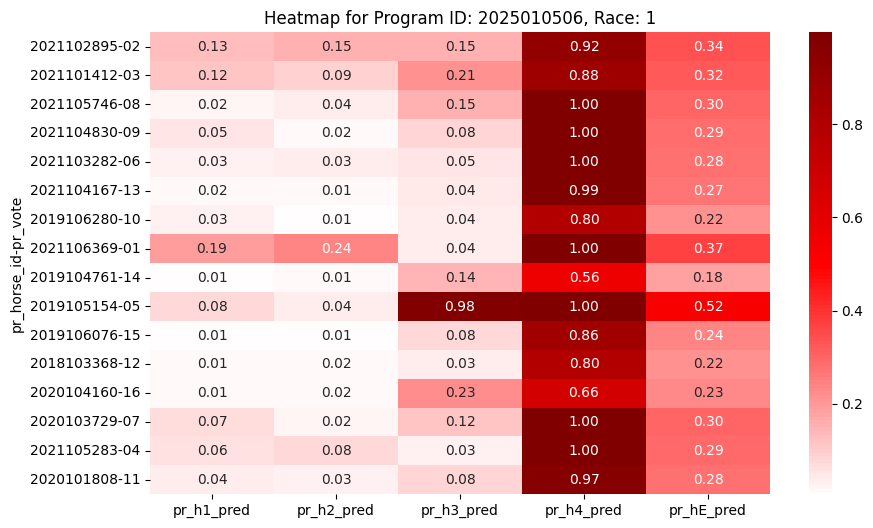

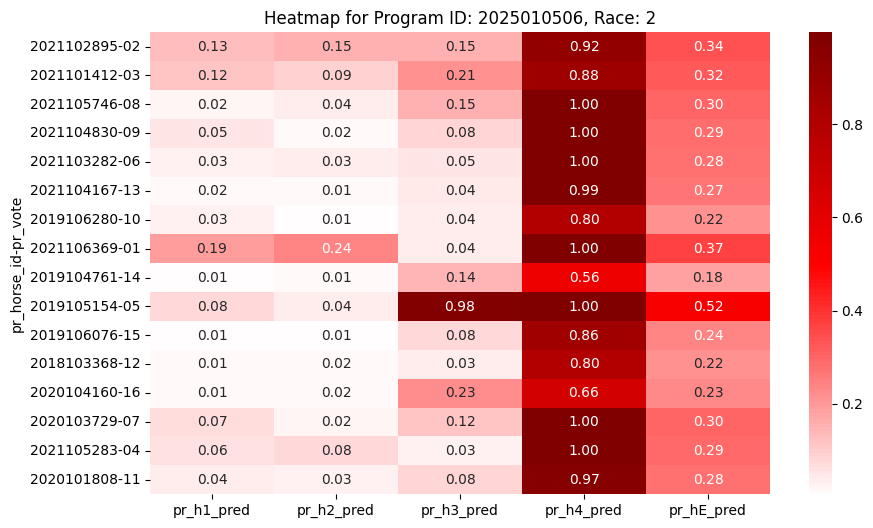

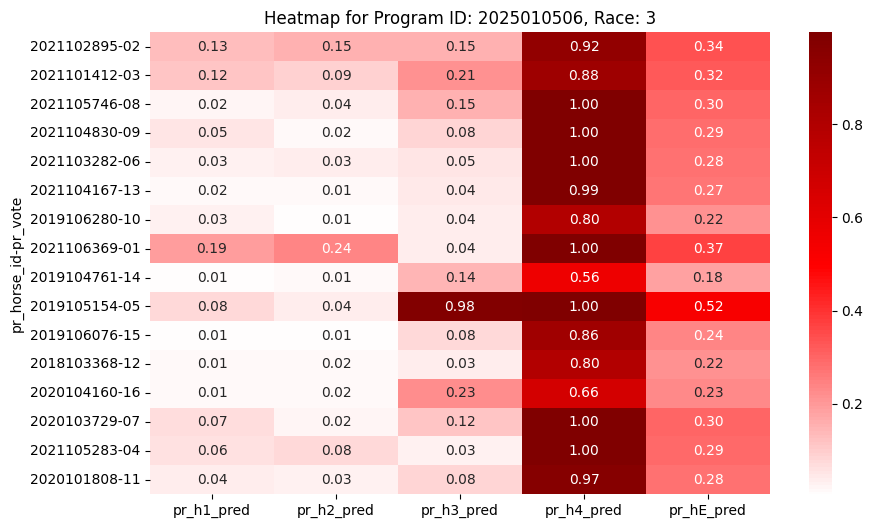

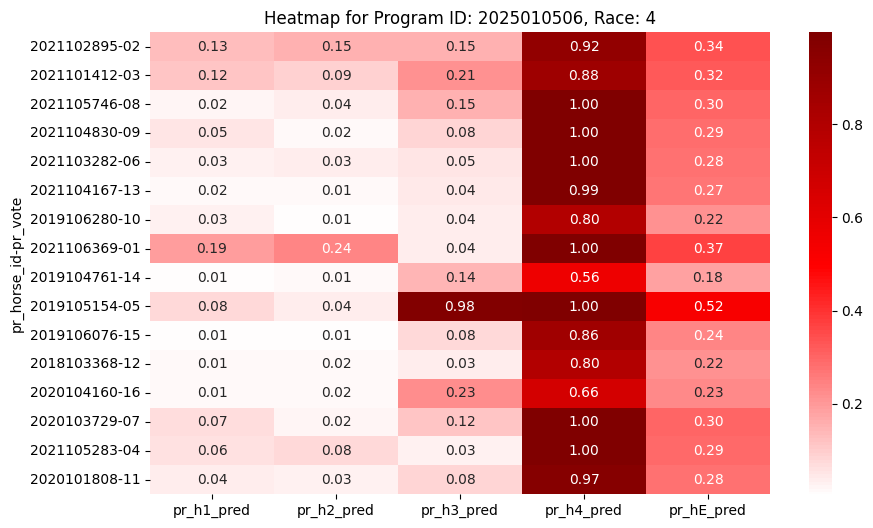

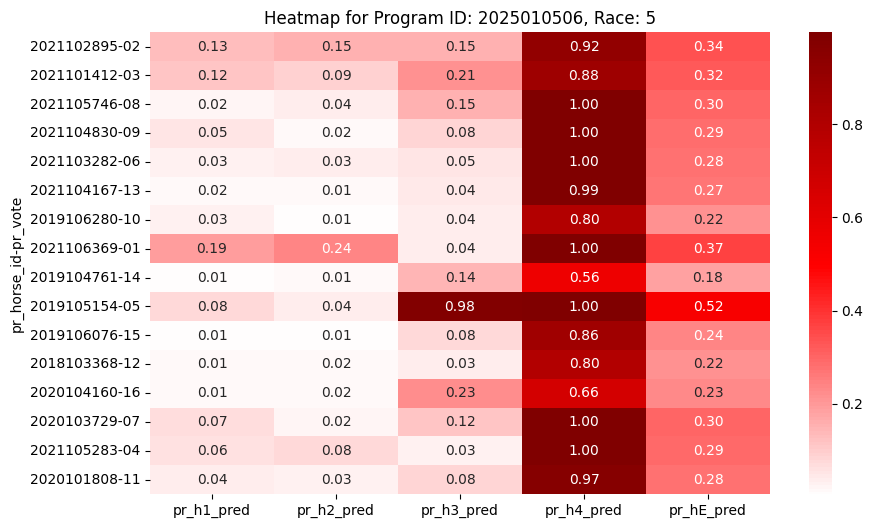

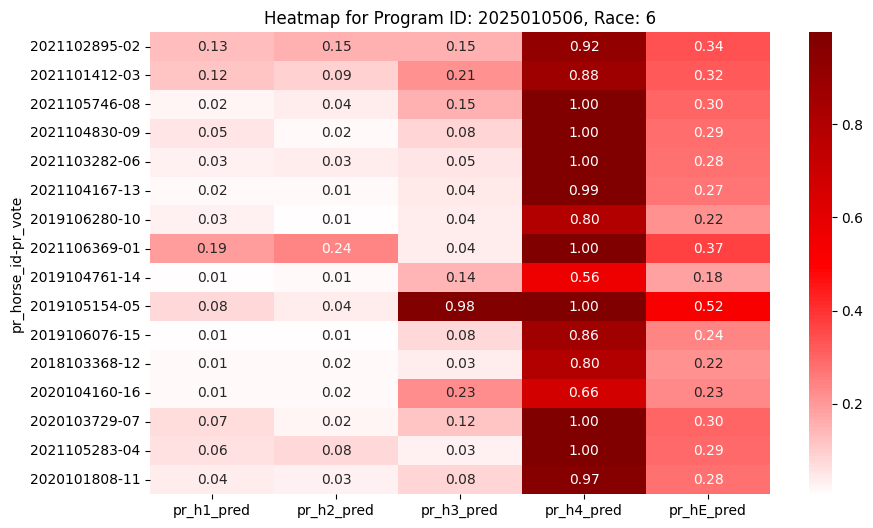

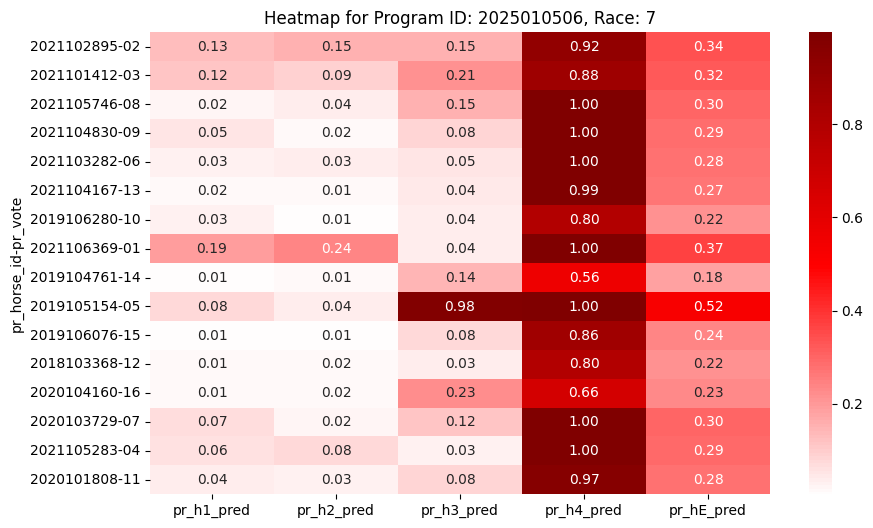

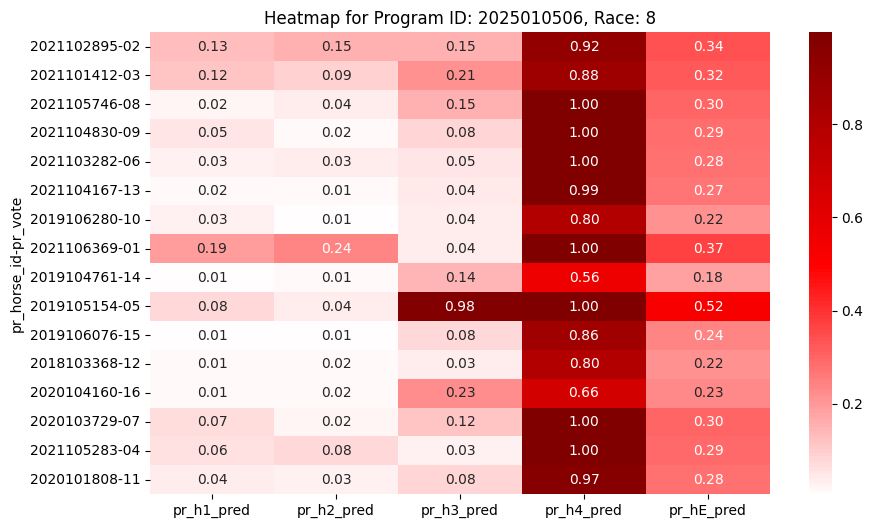

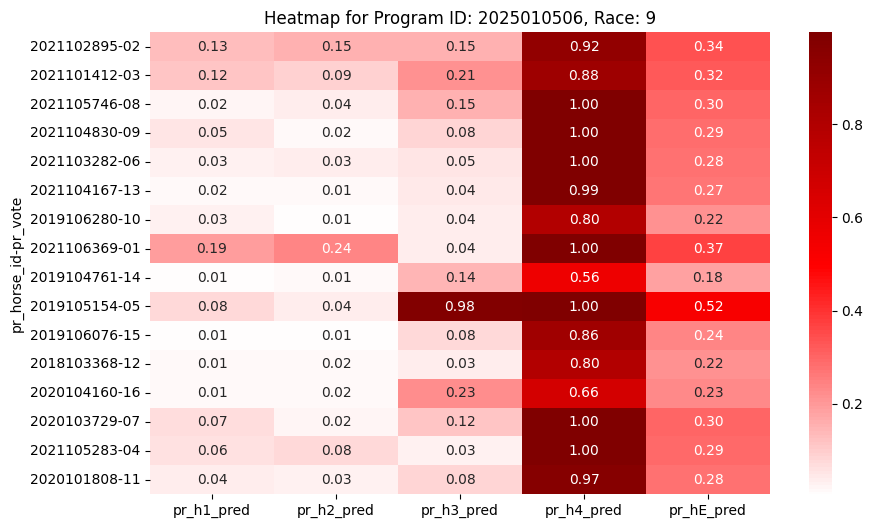

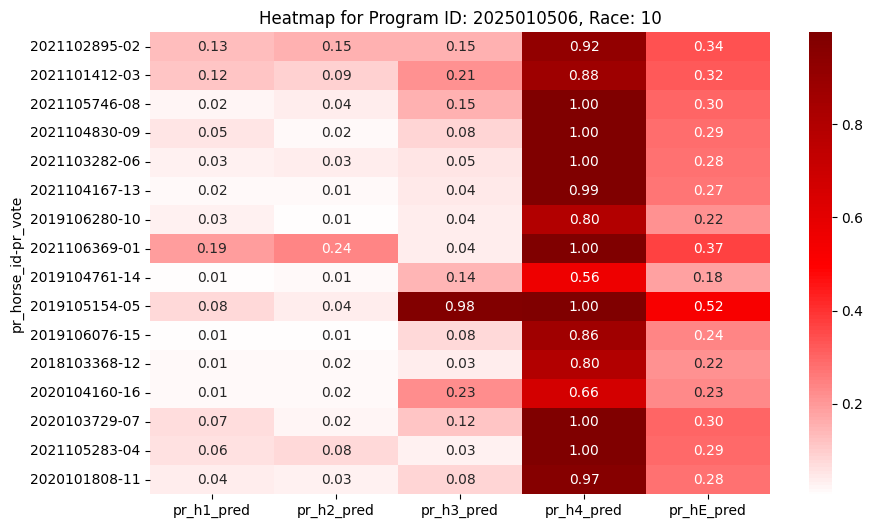

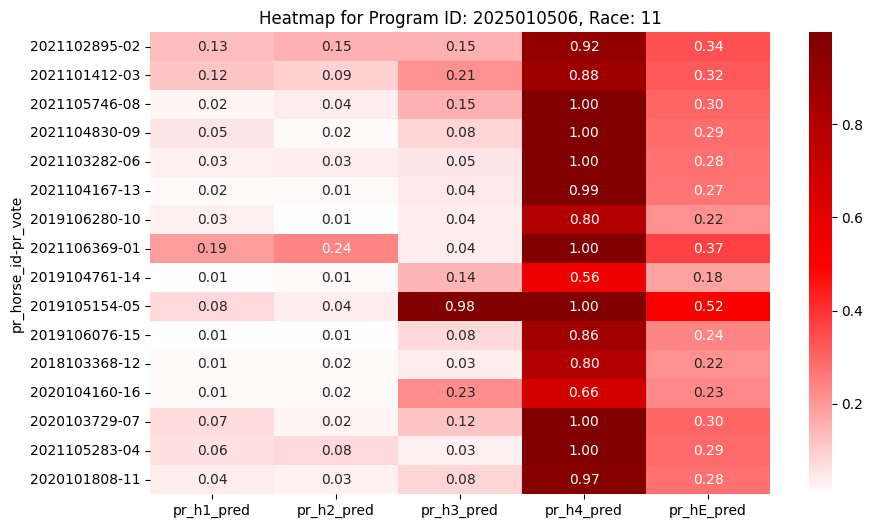

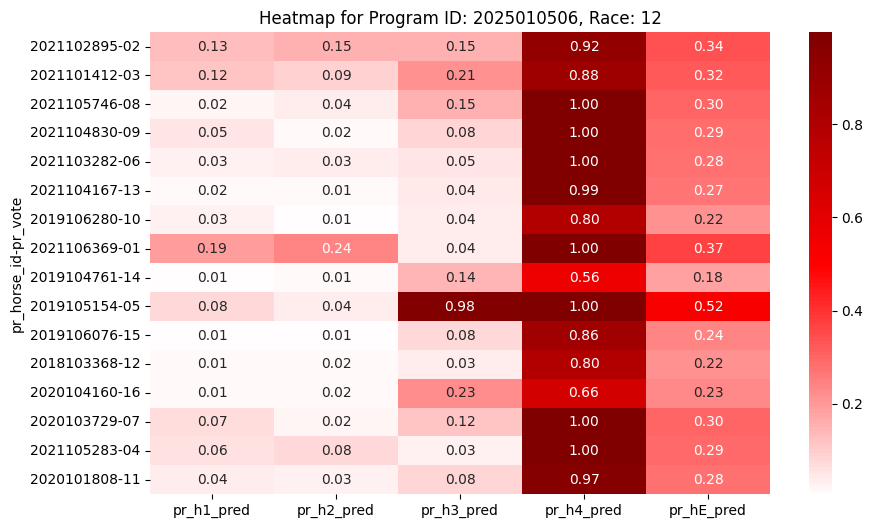

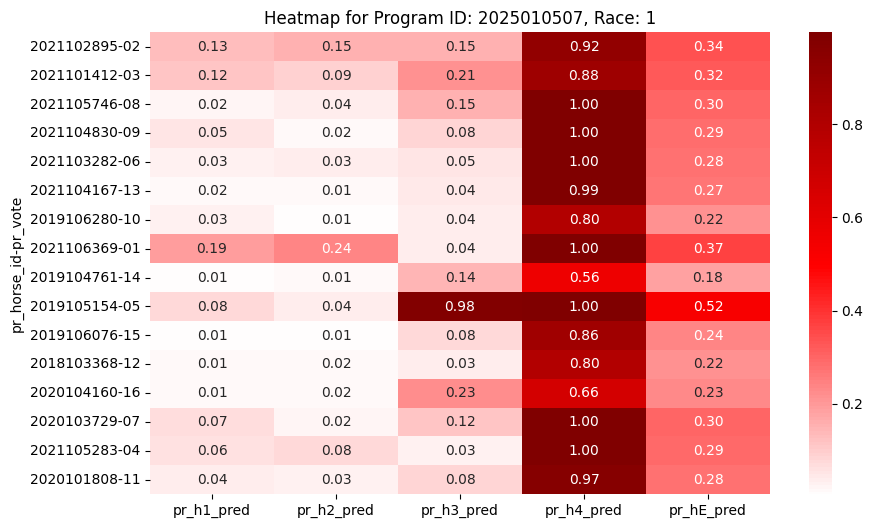

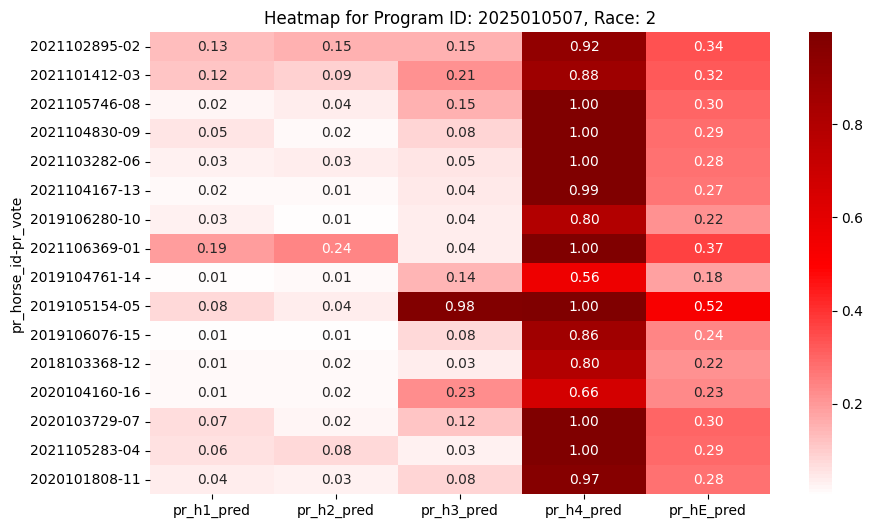

In [ ]:
# prompt: 以下のコードでヒートマップの範囲を0から1に固定してください
# 色は1側が赤色っぽく、０側がグレーにしてください
# # 各グループごとにヒートマップを描画
# for (program_id, race), group_df in grouped:
#     # pr_rankでソート
#     sorted_group_df = group_df.sort_values('pr_rank')
#     # 'pr_horse_id'-'pr_vote' の列を作成
#     sorted_group_df['pr_horse_id-pr_vote'] = sorted_group_df['pr_horse_id'].astype(str) + '-' + sorted_group_df['pr_vote'].astype(str).str.zfill(2)  # 2桁の0詰め
#     # ヒートマップのデータ作成
#     # 'pr_horse_id' を 'pr_horse_id-pr_vote' に変更
#     heatmap_data = sorted_group_df[['pr_horse_id-pr_vote', 'pr_h1_pred', 'pr_h2_pred', 'pr_h3_pred', 'pr_h4_pred', 'pr_hE_pred']]
#     heatmap_data = heatmap_data.set_index('pr_horse_id-pr_vote')
#     plt.figure(figsize=(10, 6))  # 図のサイズ調整
#     sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", center=0) # center=0でグレーを中央に
#     plt.title(f'Heatmap for Program ID: {program_id}, Race: {race}')
#     plt.show()
for (program_id, race), group_df in grouped:
    # 'pr_horse_id'-'pr_vote' の列を作成
    sorted_group_df['pr_horse_id-pr_vote'] = sorted_group_df['pr_horse_id'].astype(str) + '-' + sorted_group_df['pr_vote'].astype(str).str.zfill(2)  # 2桁の0詰め

    # ヒートマップのデータ作成
    # 'pr_horse_id' を 'pr_horse_id-pr_vote' に変更
    heatmap_data = sorted_group_df[['pr_horse_id-pr_vote', 'pr_h1_pred', 'pr_h2_pred', 'pr_h3_pred', 'pr_h4_pred', 'pr_hE_pred']]
    heatmap_data = heatmap_data.set_index('pr_horse_id-pr_vote')

    plt.figure(figsize=(10, 6))  # 図のサイズ調整
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="seismic", center=0) # center=0でグレーを中央に
    plt.title(f'Heatmap for Program ID: {program_id}, Race: {race}')
    plt.show()
